In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [106]:
df = pd.read_csv('data/skill_builder_data.csv', encoding='latin1', low_memory=False)

print(df.shape)
print(df.columns.tolist())
df.head()

(525534, 30)
['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']


,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,answer_type,sequence_id,student_class_id,position,type,base_sequence_id,skill_id,skill_name,teacher_id,school_id,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,algebra,5948,13241,126,MasterySection,5948,1.0,Box and Whisker,22763,73,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,algebra,5948,13241,126,MasterySection,5948,1.0,Box and Whisker,22763,73,0,3,4922,30799,NaN,55,0,NaN,2,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,algebra,5948,11816,22,MasterySection,5948,1.0,Box and Whisker,22763,73,0,3,42000,30799,NaN,88,0,NaN,1,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,algebra,5948,11816,22,MasterySection,5948,1.0,Box and Whisker,22763,73,0,3,4859,30059,NaN,41,0,NaN,2,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,algebra,5948,11816,22,MasterySection,5948,1.0,Box and Whisker,22763,73,3,4,124564,30060,NaN,65,0,0.0,3,3.0


In [107]:
print(f"Total Records: {len(df):,}")
print(f"Total Students: {df['user_id'].nunique():,}")
print(f"Total Problems: {df['problem_id'].nunique():,}")

df.info()

missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])


Total Records: 525,534
Total Students: 4,217
Total Problems: 26,688
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525534 entries, 0 to 525533
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              525534 non-null  int64  
 1   assignment_id         525534 non-null  int64  
 2   user_id               525534 non-null  int64  
 3   assistment_id         525534 non-null  int64  
 4   problem_id            525534 non-null  int64  
 5   original              525534 non-null  int64  
 6   correct               525534 non-null  int64  
 7   attempt_count         525534 non-null  int64  
 8   ms_first_response     525534 non-null  int64  
 9   tutor_mode            525534 non-null  object 
 10  answer_type           525534 non-null  object 
 11  sequence_id           525534 non-null  int64  
 12  student_class_id      525534 non-null  int64  
 13  position              525534 non-nul

correct
1    0.679471
0    0.320529
Name: proportion, dtype: float64
       ms_first_response  attempt_count
count       5.255340e+05  525534.000000
mean        4.799217e+04       1.502466
std         3.186983e+05      10.579588
min        -7.759575e+06       0.000000
25%         7.687000e+03       1.000000
50%         2.079100e+04       1.000000
75%         5.000000e+04       1.000000
max         8.407692e+07    3824.000000


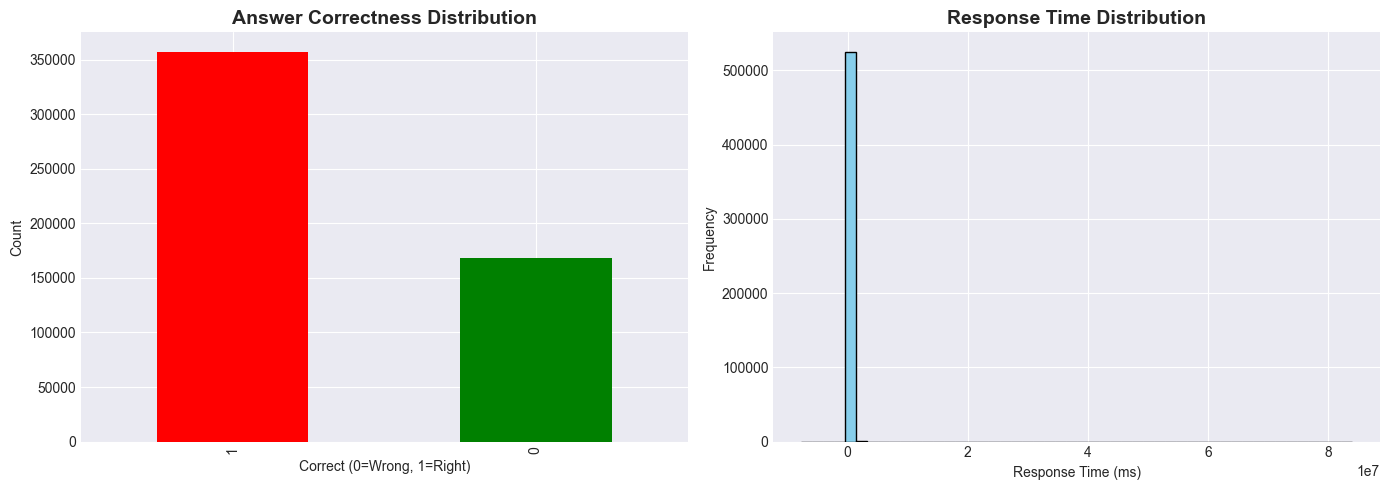

In [108]:
print(df['correct'].value_counts(normalize=True))

print(df[['ms_first_response', 'attempt_count']].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['correct'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Answer Correctness Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correct (0=Wrong, 1=Right)')
axes[0].set_ylabel('Count')

df['ms_first_response'].dropna().plot(kind='hist', bins=50, ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Response Time Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Response Time (ms)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [109]:
def create_cognitive_features(df):
    df = df.copy()
    
    df['response_time_sec'] = df['ms_first_response'] / 1000.0
    df['response_time_log'] = np.log1p(df['response_time_sec'])
    
    df['attempt_count_filled'] = df['attempt_count'].fillna(1)
    df['multiple_attempts'] = (df['attempt_count_filled'] > 1).astype(int)
    
    df['hint_count_filled'] = df['hint_count'].fillna(0)
    df['used_hints'] = (df['hint_count_filled'] > 0).astype(int)
    
    df['bottom_hint_filled'] = df['bottom_hint'].fillna(0)
    
    df['order_id_filled'] = df['order_id'].fillna(0)
    
    return df

df = create_cognitive_features(df)
print(f"New columns added: {['response_time_sec', 'response_time_log', 'attempt_count_filled', 'multiple_attempts', 'hint_count_filled', 'used_hints', 'bottom_hint_filled', 'order_id_filled']}")

New columns added: ['response_time_sec', 'response_time_log', 'attempt_count_filled', 'multiple_attempts', 'hint_count_filled', 'used_hints', 'bottom_hint_filled', 'order_id_filled']


In [110]:
def build_student_profiles(df):

    student_profiles = df.groupby('user_id').agg({
        'correct': ['mean', 'sum', 'count'],
        
        'response_time_sec': ['mean', 'median', 'std'],
        
        'attempt_count_filled': ['mean', 'max'],
        'multiple_attempts': 'mean',
        
        'hint_count_filled': ['mean', 'sum'],
        'used_hints': 'mean',
        'bottom_hint_filled': 'sum',
        
        'order_id_filled': 'max'
    }).reset_index()
    
    student_profiles.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                                 for col in student_profiles.columns.values]
    
    student_profiles.rename(columns={
        'correct_mean': 'accuracy',
        'correct_sum': 'total_correct',
        'correct_count': 'total_problems',
        'response_time_sec_mean': 'avg_response_time',
        'response_time_sec_median': 'median_response_time',
        'response_time_sec_std': 'response_time_variability',
        'attempt_count_filled_mean': 'avg_attempts',
        'attempt_count_filled_max': 'max_attempts',
        'multiple_attempts_mean': 'multiple_attempt_rate',
        'hint_count_filled_mean': 'avg_hints',
        'hint_count_filled_sum': 'total_hints',
        'used_hints_mean': 'hint_usage_rate',
        'bottom_hint_filled_sum': 'total_bottom_hints',
        'order_id_filled_max': 'max_order'
    }, inplace=True)
    
    student_profiles = student_profiles.fillna(0)
    
    return student_profiles

student_profiles = build_student_profiles(df)
print(f"Total Students: {len(student_profiles)}")
print(f"Profile Features:{student_profiles.columns.tolist()}")
student_profiles.head()

Total Students: 4217
Profile Features:['user_id', 'accuracy', 'total_correct', 'total_problems', 'avg_response_time', 'median_response_time', 'response_time_variability', 'avg_attempts', 'max_attempts', 'multiple_attempt_rate', 'avg_hints', 'total_hints', 'hint_usage_rate', 'total_bottom_hints', 'max_order']


,user_id,accuracy,total_correct,total_problems,avg_response_time,median_response_time,response_time_variability,avg_attempts,max_attempts,multiple_attempt_rate,avg_hints,total_hints,hint_usage_rate,total_bottom_hints,max_order
0,14,0.254902,13,51,26.230059,21.8840,21.904924,0.882353,4,0.039216,1.215686,62,0.509804,26.0,21617962
1,21825,0.724138,21,29,50.200552,12.0030,78.128163,0.931034,1,0.000000,0.241379,7,0.068966,2.0,23944981
2,51933,0.000000,0,1,41.531000,41.5310,0.000000,30.000000,30,1.000000,0.000000,0,0.000000,0.0,22075230
3,51950,0.833333,5,6,61.343000,25.8895,88.407718,1.833333,6,0.166667,0.500000,3,0.166667,1.0,32241238
4,52613,0.571429,4,7,14.414286,15.7280,6.850720,0.571429,1,0.000000,1.142857,8,0.285714,2.0,36259024


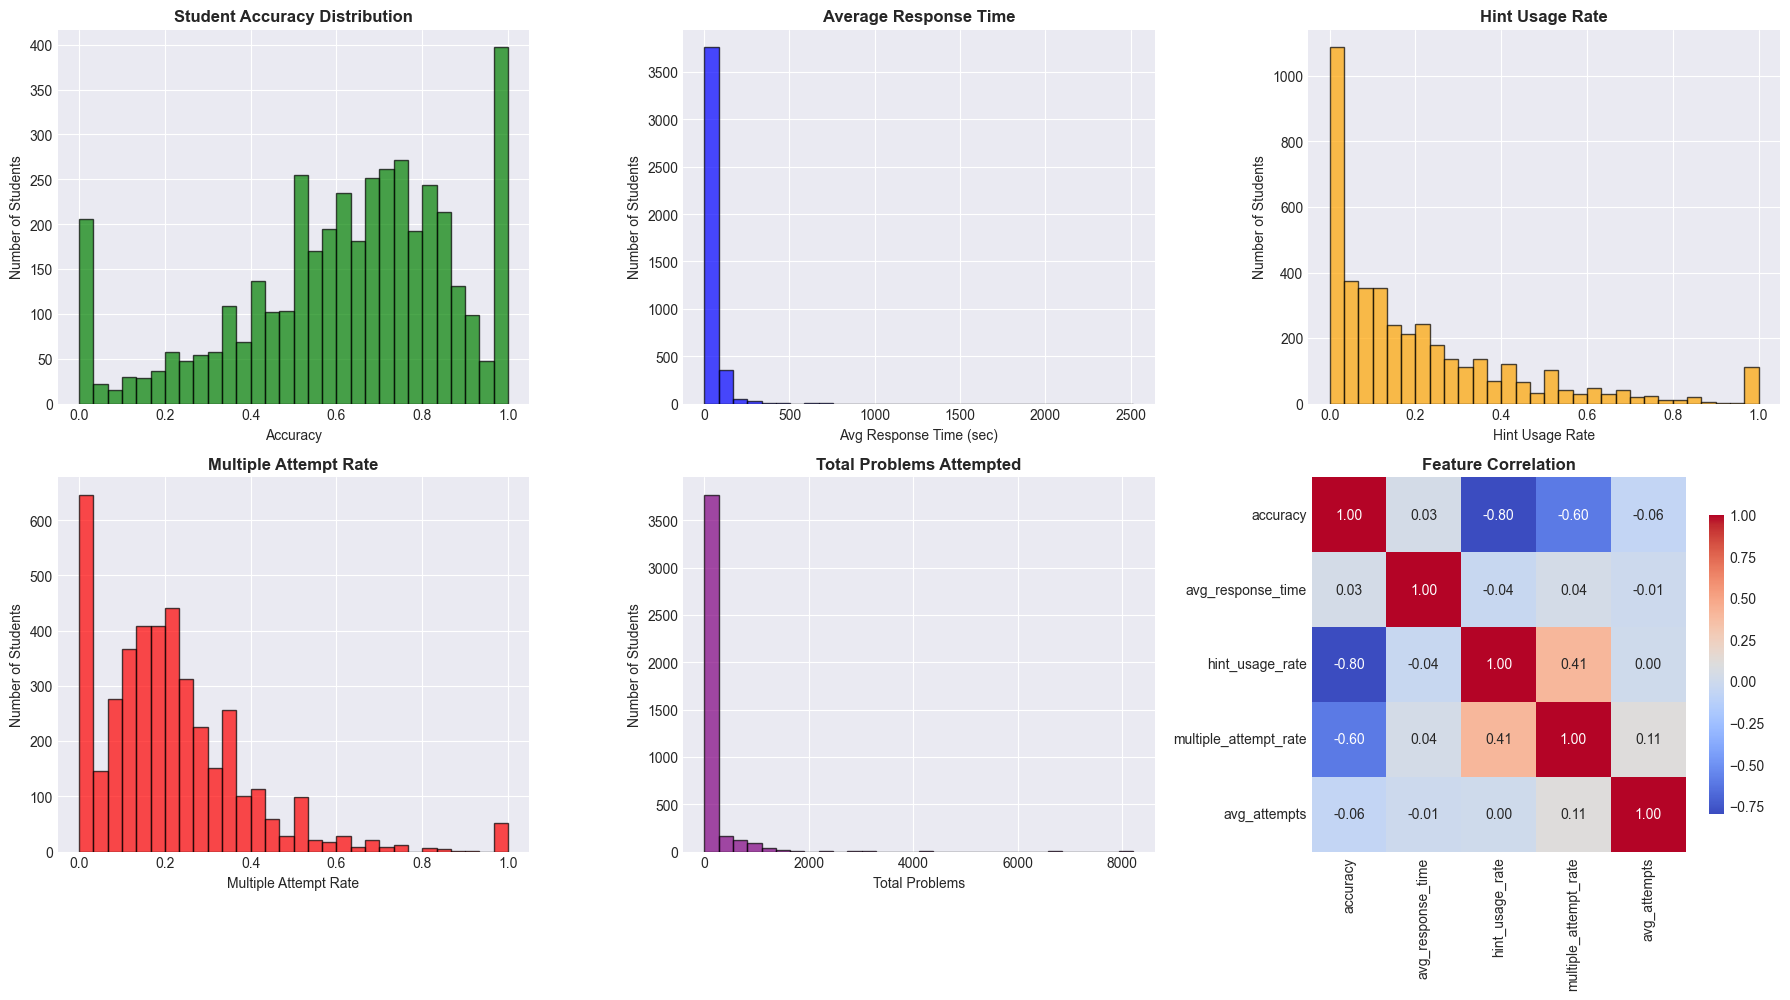

In [111]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(student_profiles['accuracy'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Student Accuracy Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Number of Students')

axes[0, 1].hist(student_profiles['avg_response_time'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Average Response Time', fontweight='bold')
axes[0, 1].set_xlabel('Avg Response Time (sec)')
axes[0, 1].set_ylabel('Number of Students')

axes[0, 2].hist(student_profiles['hint_usage_rate'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Hint Usage Rate', fontweight='bold')
axes[0, 2].set_xlabel('Hint Usage Rate')
axes[0, 2].set_ylabel('Number of Students')

axes[1, 0].hist(student_profiles['multiple_attempt_rate'], bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Multiple Attempt Rate', fontweight='bold')
axes[1, 0].set_xlabel('Multiple Attempt Rate')
axes[1, 0].set_ylabel('Number of Students')

axes[1, 1].hist(student_profiles['total_problems'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Total Problems Attempted', fontweight='bold')
axes[1, 1].set_xlabel('Total Problems')
axes[1, 1].set_ylabel('Number of Students')

corr_features = ['accuracy', 'avg_response_time', 'hint_usage_rate', 
                 'multiple_attempt_rate', 'avg_attempts']
corr_matrix = student_profiles[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 2], 
            square=True, cbar_kws={'shrink': 0.8})
axes[1, 2].set_title('Feature Correlation', fontweight='bold')

plt.tight_layout()
plt.show()


In [112]:
cognitive_features = [
    'accuracy',
    'avg_response_time',
    'median_response_time',
    'response_time_variability',
    'avg_attempts',
    'max_attempts',
    'multiple_attempt_rate',
    'avg_hints',
    'hint_usage_rate',
    'total_problems'
]

X = student_profiles[cognitive_features].copy()
y = (student_profiles['accuracy'] >= 0.7).astype(int)

print(f"Features shape: {X.shape}")
print(f"Target distribution:{y.value_counts(normalize=True)}")

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=cognitive_features)

Features shape: (4217, 10)
Target distribution:accuracy
0    0.55964
1    0.44036
Name: proportion, dtype: float64


In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} students")
print(f"Test set: {X_test.shape[0]} students")
print(f"Training set target distribution:{pd.Series(y_train).value_counts(normalize=True)}")

Training set: 3373 students
Test set: 844 students
Training set target distribution:accuracy
0    0.559146
1    0.440854
Name: proportion, dtype: float64


In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

Using device: cpu


In [115]:
class CognitiveAutoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=16):
        super().__init__()

        self.enc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.enc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.embedding = nn.Linear(32, embedding_dim)
        
        self.dec1 = nn.Linear(embedding_dim, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dec2 = nn.Linear(32, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, input_dim)
        
    def forward(self, x):
        
        x = F.relu(self.bn1(self.enc1(x)))
        x = F.relu(self.bn2(self.enc2(x)))
        x = F.relu(self.embedding(x))
        emb = x
        
        x = F.relu(self.bn3(self.dec1(x)))
        x = F.relu(self.bn4(self.dec2(x)))
        x = self.output(x)
        return x, emb

In [116]:
EPOCHS = 500
BATCH_SIZE = 64
EMBED_DIM = 16

input_dim = X_train.shape[1]
ae = CognitiveAutoencoder(input_dim, EMBED_DIM).to(device)
optimizer = optim.Adam(ae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

train_losses, val_losses = [], []
for epoch in range(EPOCHS):
    ae.train()
    optimizer.zero_grad()
    x_hat, _ = ae(X_train_tensor)
    loss = loss_fn(x_hat, X_train_tensor)
    loss.backward()
    optimizer.step()
    
    ae.eval()
    with torch.no_grad():
        x_hat_val, _ = ae(X_val_tensor)
        val_loss = loss_fn(x_hat_val, X_val_tensor)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f}")


Epoch 010 | Train Loss: 0.70670 | Val Loss: 0.74493
Epoch 020 | Train Loss: 0.46337 | Val Loss: 0.67894
Epoch 030 | Train Loss: 0.29829 | Val Loss: 0.48715
Epoch 040 | Train Loss: 0.18984 | Val Loss: 0.26697
Epoch 050 | Train Loss: 0.12138 | Val Loss: 0.14716
Epoch 060 | Train Loss: 0.08619 | Val Loss: 0.09694
Epoch 070 | Train Loss: 0.06694 | Val Loss: 0.07551
Epoch 080 | Train Loss: 0.05596 | Val Loss: 0.06449
Epoch 090 | Train Loss: 0.04889 | Val Loss: 0.05690
Epoch 100 | Train Loss: 0.04366 | Val Loss: 0.05112
Epoch 110 | Train Loss: 0.03956 | Val Loss: 0.04638
Epoch 120 | Train Loss: 0.03619 | Val Loss: 0.04276
Epoch 130 | Train Loss: 0.03351 | Val Loss: 0.03984
Epoch 140 | Train Loss: 0.03122 | Val Loss: 0.03729
Epoch 150 | Train Loss: 0.02916 | Val Loss: 0.03495
Epoch 160 | Train Loss: 0.02723 | Val Loss: 0.03291
Epoch 170 | Train Loss: 0.02543 | Val Loss: 0.03104
Epoch 180 | Train Loss: 0.02377 | Val Loss: 0.02926
Epoch 190 | Train Loss: 0.02221 | Val Loss: 0.02758
Epoch 200 | 

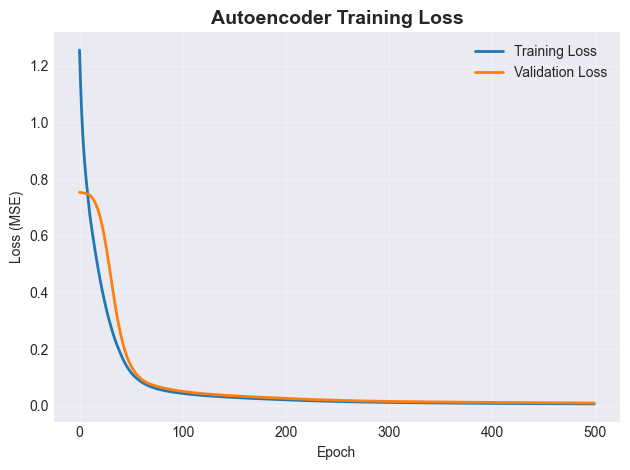

In [117]:
fig = plt.figsize=(14, 5)

plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Autoencoder Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [118]:
ae.eval()
with torch.no_grad():
    _, train_embeddings = ae(X_train_tensor)
    _, test_embeddings = ae(X_val_tensor)
train_embeddings = train_embeddings.cpu().numpy()
test_embeddings = test_embeddings.cpu().numpy()

print(f"Training embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Training embeddings shape: (3373, 16)
Test embeddings shape: (844, 16)


In [119]:
class PerformanceClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(16, 1)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.out(x)
        return torch.sigmoid(x)

clf = PerformanceClassifier(EMBED_DIM).to(device)

In [121]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)
train_emb_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
val_emb_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)

optimizer_clf = optim.Adam(clf.parameters(), lr=0.001)
loss_fn_clf = nn.BCELoss()

train_accs, val_accs = [], []
for epoch in range(300):
    clf.train()
    optimizer_clf.zero_grad()
    y_out = clf(train_emb_tensor)
    loss = loss_fn_clf(y_out, y_train_tensor)
    loss.backward()
    optimizer_clf.step()

    clf.eval()
    with torch.no_grad():
        y_pred_val = clf(val_emb_tensor)
        val_loss = loss_fn_clf(y_pred_val, y_val_tensor)
        val_pred_class = (y_pred_val.cpu().numpy() >= 0.5).astype(int)
        val_acc = (val_pred_class == y_test.values.reshape(-1, 1)).mean()
        val_accs.append(val_acc)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f} | Val Acc: {val_acc:.3f}")

Epoch 010 | Train Loss: 0.30316 | Val Loss: 0.30110 | Val Acc: 0.935
Epoch 020 | Train Loss: 0.27813 | Val Loss: 0.27262 | Val Acc: 0.942
Epoch 030 | Train Loss: 0.25470 | Val Loss: 0.24961 | Val Acc: 0.945
Epoch 040 | Train Loss: 0.23350 | Val Loss: 0.22870 | Val Acc: 0.951
Epoch 050 | Train Loss: 0.21524 | Val Loss: 0.21080 | Val Acc: 0.956
Epoch 060 | Train Loss: 0.19944 | Val Loss: 0.19480 | Val Acc: 0.959
Epoch 070 | Train Loss: 0.18833 | Val Loss: 0.18084 | Val Acc: 0.960
Epoch 080 | Train Loss: 0.17679 | Val Loss: 0.16921 | Val Acc: 0.963
Epoch 090 | Train Loss: 0.16541 | Val Loss: 0.15877 | Val Acc: 0.963
Epoch 100 | Train Loss: 0.15751 | Val Loss: 0.15050 | Val Acc: 0.967
Epoch 110 | Train Loss: 0.14756 | Val Loss: 0.14343 | Val Acc: 0.969
Epoch 120 | Train Loss: 0.13999 | Val Loss: 0.13689 | Val Acc: 0.970
Epoch 130 | Train Loss: 0.13208 | Val Loss: 0.12970 | Val Acc: 0.970
Epoch 140 | Train Loss: 0.12743 | Val Loss: 0.12407 | Val Acc: 0.973
Epoch 150 | Train Loss: 0.12099 | 

In [122]:
clf.eval()
with torch.no_grad():
    y_pred_proba = clf(val_emb_tensor).cpu().numpy().flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Performer', 'High Performer']))
print(f"Confusion Matrix:\n{confusion_matrix}")

Accuracy: 0.9751
Classification Report:
                precision    recall  f1-score   support

 Low Performer       0.97      0.98      0.98       474
High Performer       0.98      0.97      0.97       370

      accuracy                           0.98       844
     macro avg       0.98      0.97      0.97       844
  weighted avg       0.98      0.98      0.98       844

Confusion Matrix:
[[465   9]
 [ 12 358]]


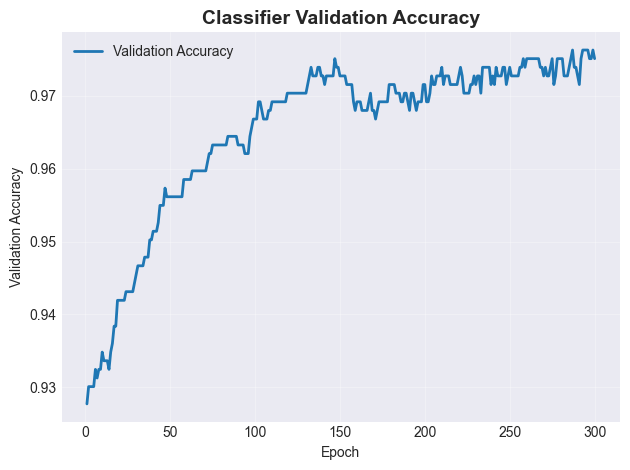

In [123]:
import matplotlib.pyplot as plt

fig = plt.figsize=(14, 5)

epochs_range = list(range(1, len(val_accs) + 1))
plt.plot(epochs_range, val_accs, label='Validation Accuracy', linewidth=2)
plt.title('Classifier Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [124]:
problem_difficulty = df.groupby('problem_id').agg({
    'correct': ['mean', 'count'],
    'ms_first_response': 'mean',
    'hint_count': 'mean',
    'attempt_count': 'mean'
}).reset_index()

problem_difficulty.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                               for col in problem_difficulty.columns.values]

problem_difficulty.rename(columns={
    'correct_mean': 'success_rate',
    'correct_count': 'attempt_count',
    'ms_first_response_mean': 'avg_response_time',
    'hint_count_mean': 'avg_hints',
    'attempt_count_mean': 'avg_attempts'
}, inplace=True)

problem_difficulty['difficulty_score'] = (
    (1 - problem_difficulty['success_rate']) * 0.5 +
    (problem_difficulty['avg_hints'] / problem_difficulty['avg_hints'].max()) * 0.3 +
    (problem_difficulty['avg_attempts'] / problem_difficulty['avg_attempts'].max()) * 0.2
)

problem_difficulty['difficulty_level'] = pd.cut(
    problem_difficulty['difficulty_score'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Easy', 'Medium', 'Hard']
)

print(f"Difficulty Distribution:")
print(problem_difficulty['difficulty_level'].value_counts())
problem_difficulty.head(10)

Difficulty Distribution:
difficulty_level
Easy      20218
Medium     6051
Hard        376
Name: count, dtype: int64


,problem_id,success_rate,attempt_count,avg_response_time,avg_hints,avg_attempts,difficulty_score,difficulty_level
0,83,0.500,4,28924.000000,0.750000,1.500000,0.288626,Easy
1,84,0.000,4,14387.750000,0.750000,2.250000,0.539305,Medium
2,85,0.200,5,16189.400000,3.400000,1.400000,0.570223,Medium
3,86,0.500,30,23361.400000,0.000000,1.000000,0.250904,Easy
4,249,0.000,1,12468.000000,0.000000,2.000000,0.501809,Medium
5,250,0.000,1,1735.000000,3.000000,1.000000,0.649984,Medium
6,251,0.000,1,1859.000000,3.000000,1.000000,0.649984,Medium
7,252,0.600,20,34681.800000,0.000000,1.000000,0.200904,Easy
8,807,0.125,8,5489.000000,2.250000,1.875000,0.551005,Medium
9,808,0.000,7,8105.428571,1.857143,1.714286,0.593838,Medium


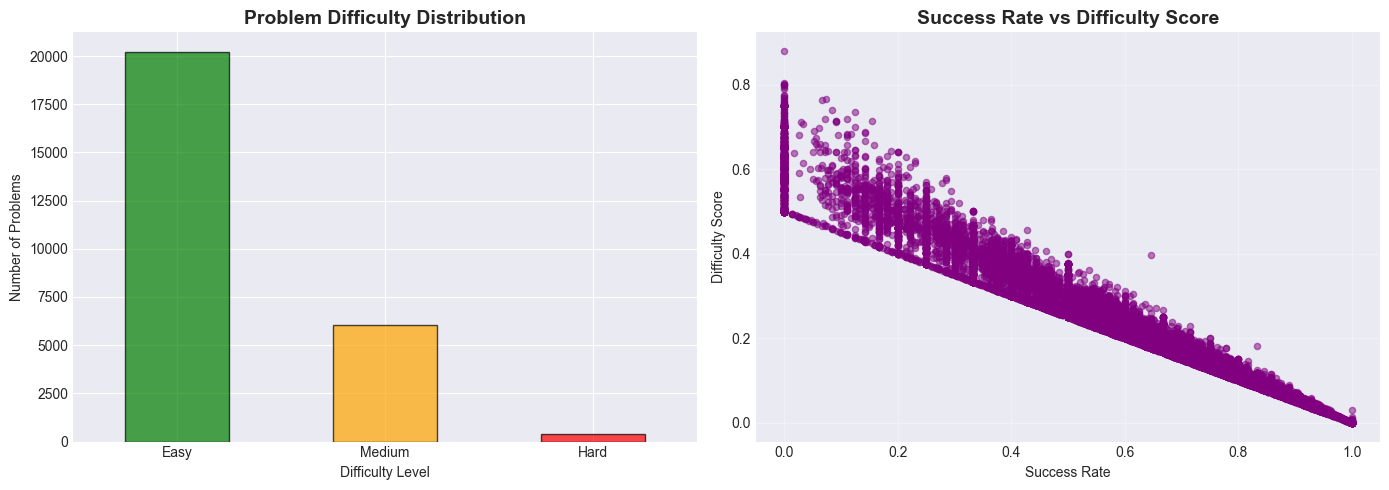

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

problem_difficulty['difficulty_level'].value_counts().plot(
    kind='bar', ax=axes[0], color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black'
)
axes[0].set_title('Problem Difficulty Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Difficulty Level')
axes[0].set_ylabel('Number of Problems')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

axes[1].scatter(problem_difficulty['success_rate'], 
                problem_difficulty['difficulty_score'], 
                alpha=0.5, s=20, color='purple')
axes[1].set_title('Success Rate vs Difficulty Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Success Rate')
axes[1].set_ylabel('Difficulty Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [126]:
class CognitiveRecommendationSystem:

    def __init__(self, ae_model, clf_model, scaler, problem_difficulty, device='cpu'):
        self.ae = ae_model
        self.clf = clf_model
        self.scaler = scaler
        self.problem_difficulty = problem_difficulty
        self.device = device

    def get_student_embedding(self, student_features):
        features_scaled = self.scaler.transform(student_features.reshape(1, -1))
        features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(self.device)
        self.ae.eval()
        with torch.no_grad():
            _, embedding = self.ae(features_tensor)
        return embedding.cpu().numpy()
    
    def predict_performance(self, embedding):
        emb_tensor = torch.tensor(embedding, dtype=torch.float32).to(self.device)
        self.clf.eval()
        with torch.no_grad():
            performance_proba = self.clf(emb_tensor).cpu().item()
        is_high_performer = performance_proba >= 0.5
        return is_high_performer, performance_proba

    def recommend_problems(self, student_features, n_recommendations=10):
        embedding = self.get_student_embedding(student_features)
        is_high_performer, performance_score = self.predict_performance(embedding)
        if is_high_performer:
            difficulty_preference = ['Medium', 'Hard']
            message = "🎯 High Performer Detected! Here are challenging problems:"
        else:
            difficulty_preference = ['Easy', 'Medium']
            message = "📚 Let's build your foundation! Here are recommended problems:"
        recommended_problems = self.problem_difficulty[
            self.problem_difficulty['difficulty_level'].isin(difficulty_preference)
        ].sort_values('difficulty_score', ascending=(not is_high_performer))
        recommendations = recommended_problems.head(n_recommendations)
        return {
            'is_high_performer': is_high_performer,
            'performance_score': performance_score,
            'message': message,
            'recommendations': recommendations
        }

    def adaptive_sequence(self, student_features, mastery_threshold=0.7):
        embedding = self.get_student_embedding(student_features)
        is_high_performer, performance_score = self.predict_performance(embedding)
        sequence = []
        if performance_score < 0.4:
            sequence = [
                self.problem_difficulty[self.problem_difficulty['difficulty_level'] == 'Easy'].sample(3),
                self.problem_difficulty[self.problem_difficulty['difficulty_level'] == 'Medium'].sample(2)
            ]
            strategy = "Foundation Building: Start with easier problems to build confidence"
        elif 0.4 <= performance_score < 0.7:
            sequence = [
                self.problem_difficulty[self.problem_difficulty['difficulty_level'] == 'Medium'].sample(3),
                self.problem_difficulty[self.problem_difficulty['difficulty_level'] == 'Hard'].sample(2)
            ]
            strategy = "Progressive Challenge: Gradually increase difficulty"
        else:
            sequence = [
                self.problem_difficulty[self.problem_difficulty['difficulty_level'] == 'Hard'].sample(5)
            ]
            strategy = "Advanced Mastery: Focus on challenging problems"
        return {
            'performance_score': performance_score,
            'strategy': strategy,
            'sequence': pd.concat(sequence).reset_index(drop=True)
        }

rec_system = CognitiveRecommendationSystem(
    ae_model=ae,
    clf_model=clf,
    scaler=scaler,           
    problem_difficulty=problem_difficulty,
    device=device
)

In [127]:
sample_student_features = X_test[0]

recommendations = rec_system.recommend_problems(sample_student_features, n_recommendations=10)

print(f"Performance Prediction:")
print(f"  - High Performer: {'Yes' if recommendations['is_high_performer'] else 'No'}")
print(f"  - Performance Score: {recommendations['performance_score']:.2%}")
print(f"{recommendations['message']}")
print(f"Top 10 Recommended Problems:")
print(recommendations['recommendations'][['problem_id', 'difficulty_level', 'difficulty_score', 'success_rate']].to_string(index=False))

Performance Prediction:
  - High Performer: Yes
  - Performance Score: 99.97%
🎯 High Performer Detected! Here are challenging problems:
Top 10 Recommended Problems:
 problem_id difficulty_level  difficulty_score  success_rate
      72566             Hard          0.880528           0.0
      93044             Hard          0.804489           0.0
      94792             Hard          0.801777           0.0
     113200             Hard          0.799968           0.0
     113196             Hard          0.799064           0.0
      93034             Hard          0.794549           0.0
      93043             Hard          0.790935           0.0
      94775             Hard          0.775423           0.0
      14563             Hard          0.772922           0.0
      93019             Hard          0.769702           0.0


In [128]:
adaptive_plan = rec_system.adaptive_sequence(sample_student_features)

print(f"Performance Score: {adaptive_plan['performance_score']:.2%}")
print(f"Strategy: {adaptive_plan['strategy']}")
print(f"Recommended Learning Sequence (5 problems):")
print(adaptive_plan['sequence'][['problem_id', 'difficulty_level', 'difficulty_score']].to_string(index=False))

Performance Score: 99.97%
Strategy: Advanced Mastery: Focus on challenging problems
Recommended Learning Sequence (5 problems):
 problem_id difficulty_level  difficulty_score
     186597             Hard          0.699677
     186677             Hard          0.699677
     170109             Hard          0.699677
      93038             Hard          0.690196
      93017             Hard          0.714102


In [129]:
def evaluate_recommendations_batch(rec_system, X_test, y_test, n_students=50):
    results = []
    
    for i in range(min(n_students, len(X_test))):
        student_features = X_test[i]
        actual_performance = y_test.iloc[i]
        
        rec = rec_system.recommend_problems(student_features, n_recommendations=5)
        
        results.append({
            'student_id': i,
            'actual_high_performer': actual_performance,
            'predicted_high_performer': rec['is_high_performer'],
            'performance_score': rec['performance_score'],
            'avg_recommended_difficulty': rec['recommendations']['difficulty_score'].mean(),
            'recommendation_match': (actual_performance == rec['is_high_performer'])
        })
    
    return pd.DataFrame(results)

evaluation_df = evaluate_recommendations_batch(rec_system, X_test, y_test, n_students=100)

print(f"Recommendation Accuracy: {evaluation_df['recommendation_match'].mean():.2%}")
print(f"Evaluation Summary:")
print(evaluation_df.describe())

Recommendation Accuracy: 90.00%
Evaluation Summary:
       student_id  actual_high_performer  performance_score  \
count  100.000000                 100.00         100.000000   
mean    49.500000                   0.45           0.427389   
std     29.011492                   0.50           0.464284   
min      0.000000                   0.00           0.000120   
25%     24.750000                   0.00           0.013920   
50%     49.500000                   0.00           0.093716   
75%     74.250000                   1.00           0.998731   
max     99.000000                   1.00           0.999993   

       avg_recommended_difficulty  
count                  100.000000  
mean                     0.335178  
std                      0.403817  
min                      0.000237  
25%                      0.000237  
50%                      0.000237  
75%                      0.817165  
max                      0.817165  


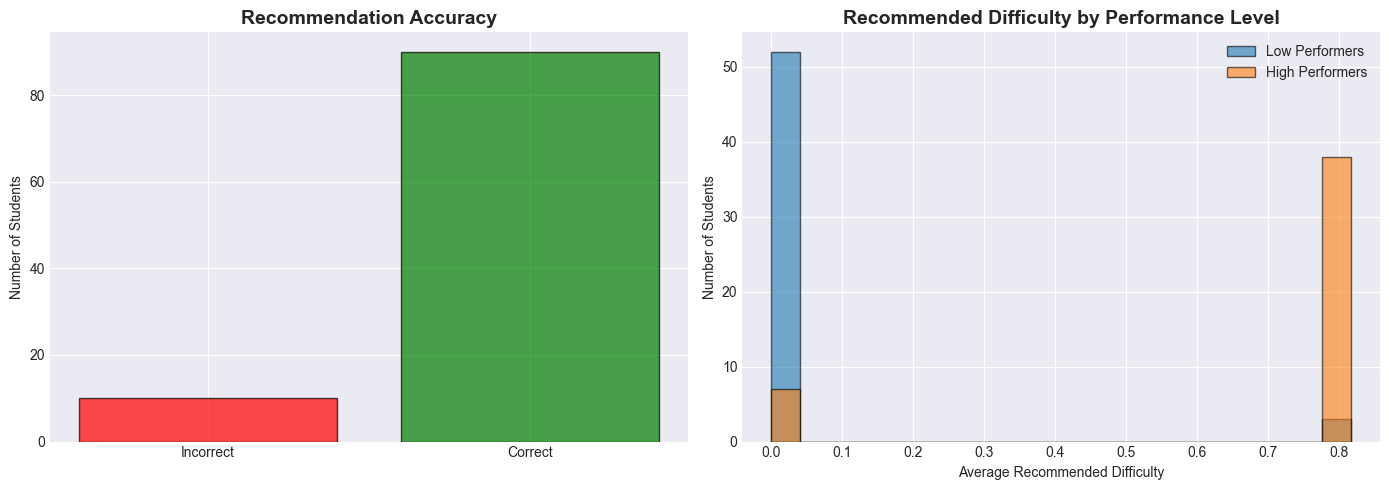

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

accuracy_data = evaluation_df['recommendation_match'].value_counts()
axes[0].bar(['Incorrect', 'Correct'], 
            [accuracy_data.get(False, 0), accuracy_data.get(True, 0)],
            color=['red', 'green'], alpha=0.7, edgecolor='black')
axes[0].set_title('Recommendation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Students')

for actual_perf in [0, 1]:
    subset = evaluation_df[evaluation_df['actual_high_performer'] == actual_perf]
    label = 'High Performers' if actual_perf == 1 else 'Low Performers'
    axes[1].hist(subset['avg_recommended_difficulty'], bins=20, alpha=0.6, 
                 label=label, edgecolor='black')
axes[1].set_title('Recommended Difficulty by Performance Level', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Recommended Difficulty')
axes[1].set_ylabel('Number of Students')
axes[1].legend()

plt.tight_layout()
plt.show()

In [131]:
def simulate_learning_gain(rec_system, student_features, n_iterations=5):
    learning_history = []
    current_features = student_features.copy()
    
    for iteration in range(n_iterations):
        embedding = rec_system.get_student_embedding(current_features)
        _, performance_score = rec_system.predict_performance(embedding)
        
        recs = rec_system.recommend_problems(current_features, n_recommendations=5)
        avg_difficulty = recs['recommendations']['difficulty_score'].mean()
        
        learning_history.append({
            'iteration': iteration + 1,
            'performance_score': performance_score,
            'avg_recommended_difficulty': avg_difficulty
        })
        
        improvement = 0.05 * (1 - performance_score)
        
        current_features_denorm = rec_system.scaler.inverse_transform(current_features.reshape(1, -1))[0]
        current_features_denorm[0] = min(1.0, current_features_denorm[0] + improvement)  # Accuracy
        current_features = rec_system.scaler.transform(current_features_denorm.reshape(1, -1))[0]
    
    return pd.DataFrame(learning_history)

low_performer_idx = np.where(y_test == 0)[0][0]
learning_progression = simulate_learning_gain(rec_system, X_test[low_performer_idx], n_iterations=10)

print("Learning Progression:")
print(learning_progression)

Learning Progression:
   iteration  performance_score  avg_recommended_difficulty
0          1           0.001860                    0.000237
1          2           0.002523                    0.000237
2          3           0.002251                    0.000237
3          4           0.002214                    0.000237
4          5           0.001463                    0.000237
5          6           0.011603                    0.000237
6          7           0.875884                    0.817165
7          8           0.914153                    0.817165
8          9           0.930977                    0.817165
9         10           0.940958                    0.817165


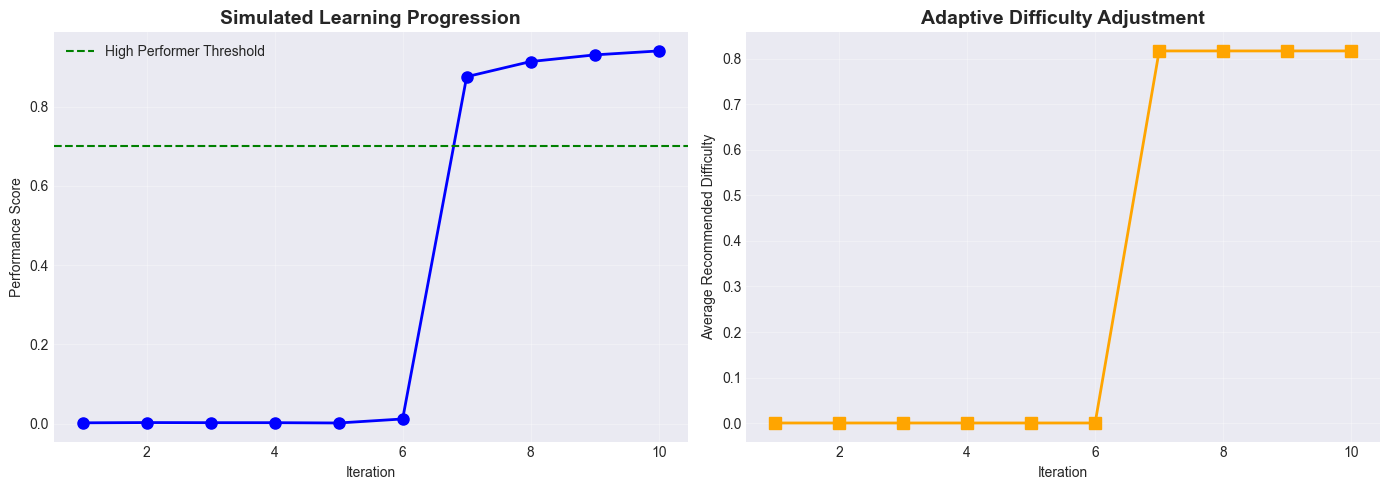

  Initial Performance: 0.19%
  Final Performance: 94.10%
  Total Improvement: 93.91%


In [132]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(learning_progression['iteration'], 
             learning_progression['performance_score'], 
             marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_title('Simulated Learning Progression', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Performance Score')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.7, color='green', linestyle='--', label='High Performer Threshold')
axes[0].legend()

axes[1].plot(learning_progression['iteration'], 
             learning_progression['avg_recommended_difficulty'], 
             marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_title('Adaptive Difficulty Adjustment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Average Recommended Difficulty')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

initial_performance = learning_progression['performance_score'].iloc[0]
final_performance = learning_progression['performance_score'].iloc[-1]
improvement = final_performance - initial_performance

print(f"  Initial Performance: {initial_performance:.2%}")
print(f"  Final Performance: {final_performance:.2%}")
print(f"  Total Improvement: {improvement:.2%}")

In [133]:
import pickle
import os
os.makedirs('models', exist_ok=True)

torch.save(ae.state_dict(), 'models/cognitive_autoencoder.pt')
torch.save(clf.state_dict(), 'models/performance_classifier.pt')

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

problem_difficulty.to_csv('models/problem_difficulty.csv', index=False)

student_profiles.to_csv('models/student_profiles.csv', index=False)

print("Saved files:")
print("  - models/cognitive_autoencoder.pt")
print("  - models/performance_classifier.pt")
print("  - models/scaler.pkl")
print("  - models/problem_difficulty.csv")
print("  - models/student_profiles.csv")

Saved files:
  - models/cognitive_autoencoder.pt
  - models/performance_classifier.pt
  - models/scaler.pkl
  - models/problem_difficulty.csv
  - models/student_profiles.csv


In [134]:
def interactive_demo():

    random_idx = np.random.randint(0, len(X_test))
    student_features = X_test[random_idx]
    actual_label = y_test.iloc[random_idx]
    
    features_denorm = scaler.inverse_transform(student_features.reshape(1, -1))[0]
    
    print(f"  • Historical Accuracy: {features_denorm[0]:.2%}")
    print(f"  • Avg Response Time: {features_denorm[1]:.1f} seconds")
    print(f"  • Response Consistency: {features_denorm[2]:.1f} seconds (median)")
    print(f"  • Average Attempts per Problem: {features_denorm[4]:.1f}")
    print(f"  • Hint Usage Rate: {features_denorm[8]:.2%}")
    print(f"  • Total Problems Attempted: {int(features_denorm[9])}")
    
    embedding = rec_system.get_student_embedding(student_features)
    is_high_performer, performance_score = rec_system.predict_performance(embedding)
    
    print(f"  • Predicted Performance Level: {'HIGH PERFORMER ⭐' if is_high_performer else 'DEVELOPING 📚'}")
    print(f"  • Performance Confidence: {performance_score:.2%}")
    print(f"  • Actual Label: {'High Performer' if actual_label == 1 else 'Low Performer'}")
    print(f"  • Prediction: {'✓ CORRECT' if (is_high_performer == actual_label) else '✗ INCORRECT'}")
    
    recommendations = rec_system.recommend_problems(student_features, n_recommendations=8)
    
    print(f"{recommendations['message']}")
    print(f"{'Problem ID':<15} {'Difficulty':<12} {'Success Rate':<15} {'Diff Score':<12}")
    for _, row in recommendations['recommendations'].head(8).iterrows():
        print(f"{int(row['problem_id']):<15} {row['difficulty_level']:<12} {row['success_rate']:.2%}{'':>10} {row['difficulty_score']:.3f}")
    
    adaptive_plan = rec_system.adaptive_sequence(student_features)
    
    print(f"Strategy: {adaptive_plan['strategy']}")
    print(f"Recommended Problem Sequence:")
    for i, (_, row) in enumerate(adaptive_plan['sequence'].head(5).iterrows(), 1):
        print(f"  {i}. Problem {int(row['problem_id'])} ({row['difficulty_level']}) - Difficulty: {row['difficulty_score']:.3f}")

interactive_demo()

  • Historical Accuracy: 80.00%
  • Avg Response Time: 29.9 seconds
  • Response Consistency: 29.2 seconds (median)
  • Average Attempts per Problem: 1.2
  • Hint Usage Rate: 20.00%
  • Total Problems Attempted: 5
  • Predicted Performance Level: HIGH PERFORMER ⭐
  • Performance Confidence: 86.21%
  • Actual Label: High Performer
  • Prediction: ✓ CORRECT
🎯 High Performer Detected! Here are challenging problems:
Problem ID      Difficulty   Success Rate    Diff Score  
72566           Hard         0.00%           0.881
93044           Hard         0.00%           0.804
94792           Hard         0.00%           0.802
113200          Hard         0.00%           0.800
113196          Hard         0.00%           0.799
93034           Hard         0.00%           0.795
93043           Hard         0.00%           0.791
94775           Hard         0.00%           0.775
Strategy: Advanced Mastery: Focus on challenging problems
Recommended Problem Sequence:
  1. Problem 186692 (Hard) - D